In [ ]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
mlflow.end_run()

# Iniciar una nueva sesión de MLflow
mlflow.start_run(run_name="Vinos clasificacion")

Out[2]: <ActiveRun: >

In [ ]:
# Se utiliza la libreria pandas para la lectura del CVS
import pandas as pd

# Se cargan los datos teniendo en cuenta la referencia de variables
df = pd.read_csv('/info_vinos.csv', header=None)
df.columns = ['Class', 'Alcohol', 'Malic_Acid', 'Ash', 'Alcalinity_of_Ash', 'Magnesium', 'Total_Phenols', 
               'Flavanoids', 'Nonflavanoid_Phenols', 'Proanthocyanins', 'Color_Intensity', 'Hue', 
               'OD280_OD315_of_Diluted_Wines', 'Proline']

# Mostrar las primeras filas para visualización
print(df.head())

   Class  Alcohol  Malic_Acid   Ash  Alcalinity_of_Ash  Magnesium  \
0      1    14.23        1.71  2.43               15.6        127   
1      1    13.20        1.78  2.14               11.2        100   
2      1    13.16        2.36  2.67               18.6        101   
3      1    14.37        1.95  2.50               16.8        113   
4      1    13.24        2.59  2.87               21.0        118   

   Total_Phenols  Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color_Intensity   Hue  OD280_OD315_of_Diluted_Wines  Proline  
0             5.64  1.04                          3.92     1065  
1             4.38  1.05  

In [ ]:
# Verificar y agregar valores faltantes
# Se realiza mediante mean, lo cual con una media de las demás columnas calcula y agrega el valor faltante, implace=true, modifica el dataframe origicnal (df)
df.fillna(df.mean(), inplace=True)


In [ ]:
# Detección y tratamiento de valores atípicos 
# recorre las columnas del dataframe buscando solo valores numericos, enteros o decimales y devuelve el nombre de las columnas
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    # identifica las valores del primer 25% quartil 
    Q1 = df[col].quantile(0.25) 
    # identifica las valores del tercer 75% quartil 
    Q3 = df[col].quantile(0.75)
    # con esta formula calculamos donde se enceuntra el 50% de los datos 
    IQR = Q3 - Q1
     # Para elmiminar valores atipiocs se busca los valores que estan muy debako o mun encima del cuartilio tomoando como dedida 1.5 el IQR.
    df = df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]


In [ ]:
# Balanceo de la variable clase (cultivo o variedad de uva) utilizando SMOTE
# Se separan los conjuntos de datos
# Elimina del dataframe la columna cultivo y carga las demas columnas en el Dataframe
X = df.drop('Class', axis=1)
# Extrae del dataframe unicamente la variable cultivo para realizar el muestreo
y = df['Class']
# random 42 garantiza que siempte la ejecucións sea la misma 
smote = SMOTE(random_state=42)
# Realiza un sobremuestreo SMOTE agregando valores a la clase que menos muestras tienes para balancear el número de muestras por cada clase
X_resampled, y_resampled = smote.fit_resample(X, y)


In [ ]:
# Escalar los datos numéricos para mejorar el rendimiento de algunos modelos
# escala los datos para determinando una media de cero y una desviación estandar de 1, así escala los datos numericos para mejor entendimiento del modelo 
# Catidad 22 Valor 30000 - Escalados con una muestra de datos -1.1	-1.5
scaler = StandardScaler()
# X_resampled_scaled Son los datos escalados para entrenar modelos (Machine learning)
X_resampled_scaled = scaler.fit_transform(X_resampled)


In [ ]:
# Dividir los datos se entranan con el 70% y se prueba con el otro 30 %
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.3, random_state=42)

In [ ]:
# Entrenamiento con Random Forest
# RandomForest utiliza diferentes arboles de datos para mejorar la presición del modelo de datos
rf_model = RandomForestClassifier(random_state=42)
# El modelo aprende de las variables analizadas (X_train) del conjunto de datos de entrenamiento y la variable a predecir y_train para aprender 
# los patrones y realizar las predicciones
rf_model.fit(X_train, y_train)
# Una vez entrenado el modelo esta linea realiza las predicciones en una lista llamada y_pred_rf, representa la clse de uva que el modelo predice con el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Métricas de rendimiento
# Se calcula la presición del modelo, con las predicciones correctas obtenidas de comparar el conjunto de prueba y las predichas por el modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
# otorga un puntaje ponderado a cada clase de uva según las predicciones correctas, average='weighted' le da mas peso a las clases con más ejemplos
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
# Mide los aciertos globales y no especificamente las clases, opción correcta si las clases estan balanceadas.
print("Random Forest Presición:", accuracy_rf)
# Mide los aciertos por cada clase y utiliza una formula que da más peso a las clases con mas muestras.
print("Random Forest F1 Puntaje:", f1_rf)
# El resultado de estas variables puede determinarse así: Excelente 1.0, Bueno 0.7 - 0.9 REndimiento bueno Aceptable 0.5 -  0.7 Rendimiento aceptable  menos de 0.5 el modelo no esta funcionando biuen (mal clasificado, se requieren mas datos)

# Registrar las métricas y el modelo en MLflow
mlflow.log_metric("accuracy_rf", accuracy_rf)
mlflow.log_metric("f1_rf", f1_rf)
mlflow.sklearn.log_model(rf_model, "RandomForestModel")


Random Forest Presición: 1.0
Random Forest F1 Puntaje: 1.0


2024/09/13 01:01:17 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-2854a-57e8c-f014e-5/tmpse4tj3tz/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/09/13 01:01:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Out[9]: <mlflow.models.model.ModelInfo at 0x7f1afd854d60>

In [ ]:
# Entrenamiento con SVM
# SVN Crea vectores de cada clase buscando encontrar formas de separlkas e identificarlas y así clasificar mejor el modelo.
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Métricas de rendimiento
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print("SVM Presición:", accuracy_svm)
print("SVM F1 Puntaje:", f1_svm)

# Registrar las métricas y el modelo en MLflow
mlflow.log_metric("accuracy_svm", accuracy_svm)
mlflow.log_metric("f1_svm", f1_svm)
mlflow.sklearn.log_model(rf_model, "SVMModel")


SVM Presición: 1.0
SVM F1 Puntaje: 1.0


2024/09/13 01:04:43 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-2854a-57e8c-f014e-5/tmp02ai3p44/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/09/13 01:04:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Out[11]: <mlflow.models.model.ModelInfo at 0x7f1b24504d00>

In [ ]:
# Entrenamiento con Gradient Boosting
# Gradient Boosting utiliza arboles de datos de forma secuencial, corrigiendo en los errores en cada arbol nuevo
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Métricas de rendimiento
accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')

print("Gradient Boosting Presición:", accuracy_gb)
print("Gradient Boosting F1 Puntaje:", f1_gb)


# Registrar las métricas y el modelo en MLflow
mlflow.log_metric("accuracy_gb", accuracy_gb)
mlflow.log_metric("f1_gb", f1_gb)
mlflow.sklearn.log_model(rf_model, "GBModel")


Gradient Boosting Presición: 0.8727272727272727
Gradient Boosting F1 Puntaje: 0.8723232323232323


2024/09/13 01:05:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-2854a-57e8c-f014e-5/tmp6a2do0f9/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/09/13 01:05:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Out[13]: <mlflow.models.model.ModelInfo at 0x7f1afcbb7cd0>

In [ ]:
# Comparación de los resultados
# Se crea un dataframe con los resultados de los 3 modelos
model_performance = pd.DataFrame({
    'Modelo': ['Random Forest', 'SVM', 'Gradient Boosting'],
    'Presición': [accuracy_rf, accuracy_svm, accuracy_gb],
    'F1 Puntaje': [f1_rf, f1_svm, f1_gb]
})

print(model_performance)

              Modelo  Presición  F1 Puntaje
0      Random Forest   1.000000    1.000000
1                SVM   1.000000    1.000000
2  Gradient Boosting   0.872727    0.872323


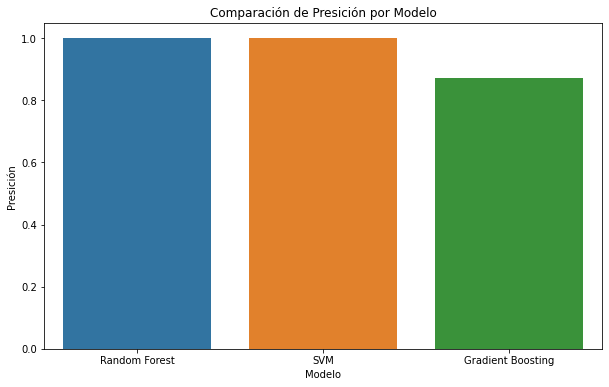

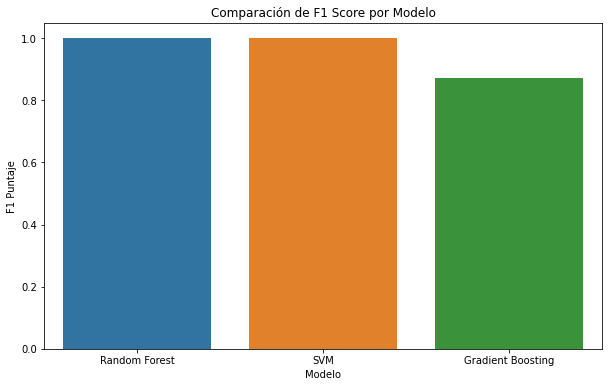

In [ ]:
# Gráficos de comparación de las métricas de rendimiento
plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='Presición', data=model_performance)
plt.title('Comparación de Presición por Modelo')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='F1 Puntaje', data=model_performance)
plt.title('Comparación de F1 Score por Modelo')
plt.show()


In [ ]:
new_samples = pd.DataFrame([
    [13.72, 1.43, 2.5, 16.7, 108, 3.4, 3.67, 0.19, 2.04, 6.8, 0.89, 2.87, 1285],
    [12.37, 0.94, 1.36, 10.6, 88, 1.98, 0.57, 0.28, 0.42, 1.95, 1.05, 1.82, 520]
], columns=['Alcohol', 'Malic_Acid', 'Ash', 'Alcalinity_of_Ash', 'Magnesium', 'Total_Phenols', 
            'Flavanoids', 'Nonflavanoid_Phenols', 'Proanthocyanins', 'Color_Intensity', 'Hue', 
            'OD280_OD315_of_Diluted_Wines', 'Proline'])

# Escalar las nuevas muestras
new_samples_scaled = scaler.transform(new_samples)

# Realizar la predicción Random Forest
predictions = rf_model.predict(new_samples_scaled)

# Mostrar los resultados de la predicción
print("Predicciones Random Forest para las nuevas muestras:")
for i, pred in enumerate(predictions):
    print(f"Muestra {i + 1}: Variedad de uva {pred}")

# Realizar la predicción con SVM
predictions = svm_model.predict(new_samples_scaled)

# Mostrar los resultados de la predicción
print("Predicciones SVM para las nuevas muestras:")
for i, pred in enumerate(predictions):
    print(f"Muestra {i + 1}: Variedad de uva {pred}")

# Realizar la predicción Gradient Boosting
predictions = gb_model.predict(new_samples_scaled)

# Mostrar los resultados de la predicción
print("Predicciones Gradient Boosting para las nuevas muestras:")
for i, pred in enumerate(predictions):
    print(f"Muestra {i + 1}: Variedad de uva {pred}")

Predicciones Random Forest para las nuevas muestras:
Muestra 1: Variedad de uva 1
Muestra 2: Variedad de uva 2
Predicciones SVM para las nuevas muestras:
Muestra 1: Variedad de uva 1
Muestra 2: Variedad de uva 2
Predicciones Gradient Boosting para las nuevas muestras:
Muestra 1: Variedad de uva 1
Muestra 2: Variedad de uva 2
